# Agriculture Yield Analysis
## Introduction

In this analysis, we aim to answer a few research questions regarding agricultural yields to demonstrate how data science is a vital tool for this generation's scientific endeavors.

## Table of Contents
- [About the Dataset](#aboutdataset)
- [Research Questions](#researchquestions)
- [Data Wrangling](#datawrangling)
- [Exploratory Data Analysis](#eda)
- [Summary of Insights](#summary)

<hr>

### About the Dataset
<a id="aboutdataset"></a>

The dataset is acquired for free from Kaggle by Samuel Oti Attakorah. This dataset contains agricultural data for 1,000,000 samples. Link to the [dataset](https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield/data).

- **Region**: The geographical region where the crop is grown (North, East, South, West).
- **Soil_Type**: The type of soil in which the crop is planted (Clay, Sandy, Loam, Silt, Peaty, Chalky).
- **Crop**: The type of crop grown (Wheat, Rice, Maize, Barley, Soybean, Cotton).
- **Rainfall_mm**: The amount of rainfall received in millimeters during the crop growth period.
- **Temperature_Celsius**: The average temperature during the crop growth period, measured in degrees Celsius.
- **Fertilizer_Used**: Indicates whether fertilizer was applied (True = Yes, False = No).
- **Irrigation_Used**: Indicates whether irrigation was used during the crop growth period (True = Yes, False = No).
- **Weather_Condition**: The predominant weather condition during the growing season (Sunny, Rainy, Cloudy).
- **Days_to_Harvest**: The number of days taken for the crop to be harvested after planting.
- **Yield_tons_per_hectare**: The total crop yield produced, measured in tons per hectare.


As stated in the collection methodology,
> The data does not come from a specific agricultural study or real-world measurements but is based on commonly understood agricultural factors that influence crop yield.

<hr>



## Research Questions
<a id="researchquestions"></a>
1. Does applying fertilizer yield better results when combined with irrigation compared to when used alone?
2. Is there a statistically significant difference in the mean yield between Peaty soil and Loam soil across all regions?
3. How does the distribution of yield change for "Maize" vs. "Wheat" when the Weather_Condition shifts from Sunny to Rainy?
4. What is the average Days_to_Harvest for each crop, and is there a correlation between growth duration and yield?
5. Is the average temperature in the "North" region significantly different from the "South" region during the growth periods recorded?

<hr>

## Data Wrangling
<a id="datawrangling"></a>
We will first prepare the environment by loading the necessary libraries and importing the dataset. Next, we will assess the dataset to see if it needs cleaning.

### Preparing the Environment

In [ ]:
# Import the libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

df = pd.read_csv("/content/drive/MyDrive/Portfolio/Datasets/crop_yield.csv")

### Assessing the Dataset

In [ ]:
df.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,West,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,South,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,North,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,North,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,South,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


In [ ]:
df.describe()

,Rainfall_mm,Temperature_Celsius,Days_to_Harvest,Yield_tons_per_hectare
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,549.981901,27.504965,104.495025,4.649472
std,259.851320,7.220608,25.953412,1.696572
min,100.000896,15.000034,60.000000,-1.147613
25%,324.891090,21.254502,82.000000,3.417637
50%,550.124061,27.507365,104.000000,4.651808
75%,774.738520,33.753267,127.000000,5.879200
max,999.998098,39.999997,149.000000,9.963372


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


In [ ]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

There seems to be no nulls and duplicates in the dataset so we can proceed.

## Exploratory Data Analysis
<a id="eda"></a>
## Q1: Does applying fertilizer yield better results when combined with irrigation compared to when used alone?

### Check for ANOVA Assumptions

Normality of Residuals: This is formally tested using the Shapiro-Wilk test. This tests the null hypothesis that the data is normally distributed. Since our sample is large, we can use their histograms instead for visual inspection.

Homogeneity of Variance: We can formally test the homogeneity of variances using the Levene’s Test. This tests the null hypothesis that variances are homogeneous. We reject the null hypothesis if p-value < 0.05.

In [ ]:
# Prepare samples
fert_only = df.query("(Fertilizer_Used == True) & (Irrigation_Used == False)")[['Yield_tons_per_hectare']].sample(n=500)
irrig_only = df.query("(Fertilizer_Used == False) & (Irrigation_Used == True)")[['Yield_tons_per_hectare']].sample(n=500)
fert_irrig = df.query("(Fertilizer_Used == True) & (Irrigation_Used == True)")[['Yield_tons_per_hectare']].sample(n=500)

fert_irrig_yields = df[['Fertilizer_Used', 'Irrigation_Used', 'Yield_tons_per_hectare']].sample(n=500)

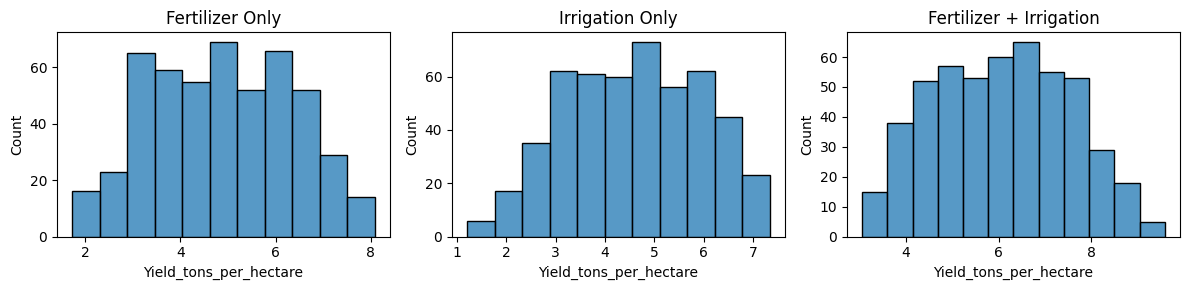

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

sns.histplot(data=fert_only, x='Yield_tons_per_hectare', ax=axes[0])
axes[0].set_title("Fertilizer Only")

sns.histplot(data=irrig_only, x='Yield_tons_per_hectare', ax=axes[1])
axes[1].set_title("Irrigation Only")

sns.histplot(data=fert_irrig, x='Yield_tons_per_hectare', ax=axes[2])
axes[2].set_title("Fertilizer + Irrigation")

plt.tight_layout()
plt.show()

In [ ]:
# Levene's Test for Homogeneity of Variance
levene_stat, levene_p_value = stats.levene(fert_irrig['Yield_tons_per_hectare'], fert_only['Yield_tons_per_hectare'])

if levene_p_value > 0.05:
    print("The variances are equal", levene_p_value)
else:
    print("Violated! The variances are not equal", levene_p_value)

The variances are equal 0.2188359878076465


The assumptions are met thus we proceed with the Two-Way ANOVA.

### Hypothesis testing using Two-Way ANOVA

We perform hypothesis testing using the Two-Way ANOVA since there are two factors (fertilizer and irrigation) to consider for the yield performance.

|Null Hypothesis $H_{0}$|Alternative Hypothesis $H_{a}$|
|---|---|
|There are no significant differences in the mean between the groups (factor levels) of the first factor.|There is a significant difference in the mean between the groups (factor levels) of the first factor.|
|There are no significant differences in the mean between the groups (factor levels) of the second factor.|There is a significant difference in the mean between the groups (factor levels) of the second factor.|
|One factor has no effect on the effect of the other factor. (no interaction effect)|One factor has an effect on the effect of the other factor.|

In [ ]:
formula = 'Yield_tons_per_hectare ~ C(Fertilizer_Used) + C(Irrigation_Used) + C(Fertilizer_Used):C(Irrigation_Used)'
model = ols(formula, data=fert_irrig_yields).fit()
anova_result = sm.stats.anova_lm(model, type=2)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(Fertilizer_Used),1.0,301.396172,301.396172,147.404728,7.021700e-30
C(Irrigation_Used),1.0,210.464524,210.464524,102.932515,4.188189e-22
C(Fertilizer_Used):C(Irrigation_Used),1.0,0.104824,0.104824,0.051267,8.209669e-01
Residual,496.0,1014.163542,2.044685,NaN,NaN


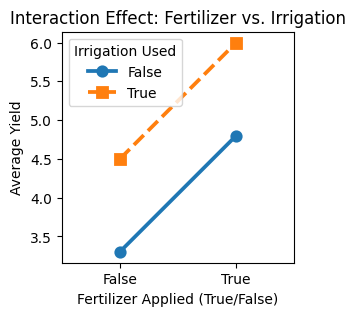

In [ ]:
plt.figure(figsize=(3, 3))
sns.pointplot(data=df, x='Fertilizer_Used', y='Yield_tons_per_hectare', hue='Irrigation_Used', markers=['o', 's'], linestyles=['-', '--'])

# Add labels for clarity
plt.title('Interaction Effect: Fertilizer vs. Irrigation')
plt.xlabel('Fertilizer Applied (True/False)')
plt.ylabel('Average Yield')
plt.legend(title='Irrigation Used')
plt.show()

### Interpretation:
> Does applying fertilizer yield better results when combined with irrigation compared to when used alone?

The two-way ANOVA resulted to significant p-values for the main effects A and B but an insignificant p-value for the interaction effect. This suggests that the using Fertlizer and Irrigation alone yield better results but using them together do not give special benefits.

**Summary**:
Fertilizer is good alone. Irrigation is good alone. Fertilizer combined with Irrigation does not have special benefits.
<hr>

## Q2: Is there a statistically significant difference in the mean yield between Peaty soil and Loam soil across all regions?

In [ ]:
# Prepare samples
peaty_soil = df.query('Soil_Type == "Peaty"', )[['Yield_tons_per_hectare']].sample(n=500).reset_index(drop=True)
loam_soil = df.query('Soil_Type == "Loam"')[['Yield_tons_per_hectare']].sample(n=500).reset_index(drop=True)

df_soils = pd.concat([peaty_soil, loam_soil], axis=1)
df_soils.columns = ['Peaty_Yield', 'Loam_Yield']
df_soils.head()

,Peaty_Yield,Loam_Yield
0,5.433835,5.366639
1,4.952831,4.399637
2,6.366805,5.065888
3,6.518979,4.043360
4,4.373047,3.994369


### Check for ANOVA Assumptions

Normality of Residuals: This is formally tested using the Shapiro-Wilk test. This tests the null hypothesis that the data is normally distributed. Since our sample is large, we can use their histograms instead for visual inspection.

Homogeneity of Variance: We can formally test the homogeneity of variances using the Levene’s Test. This tests the null hypothesis that variances are homogeneous. We reject the null hypothesis if p-value < 0.05.

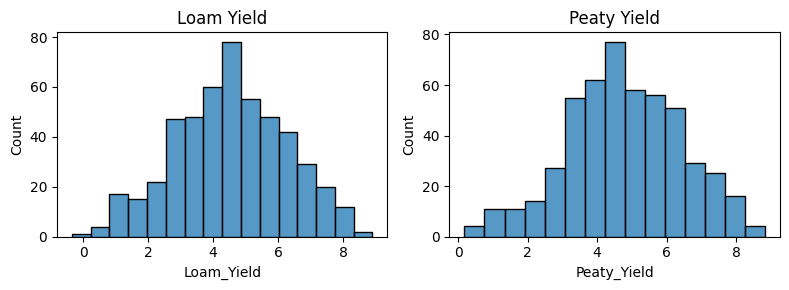

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

sns.histplot(data=df_soils, x='Loam_Yield', ax=axes[0])
axes[0].set_title("Loam Yield")

sns.histplot(data=df_soils, x='Peaty_Yield', ax=axes[1])
axes[1].set_title("Peaty Yield")

plt.tight_layout()
plt.show()

In [ ]:
# Levene's Test for Homogeneity of Variance
levene_stat, levene_p_value = stats.levene(df_soils['Loam_Yield'], df_soils['Peaty_Yield'])

if levene_p_value > 0.05:
    print("The variances are equal", levene_p_value)
else:
    print("Violated! The variances are not equal", levene_p_value)

The variances are equal 0.5364473297909644


The assumptions are met thus we proceed with the One-Way ANOVA.

### Hypothesis Testing using One-Way ANOVA

$H_{0}$: The means of both yields are equal $(\mu_{loam} = \mu_{peaty})$

$H_{a}$: The means of both yields are significantly different. $(\mu_{loam} \neq \mu_{peaty})$

In [ ]:
f_statistic, p_value = stats.f_oneway(df_soils['Loam_Yield'], df_soils['Peaty_Yield'])

if p_value < 0.05:
    print("There is a significant difference between the means.")
else:
    print("There is no significant difference between the means.")

There is a significant difference between the means.


In [ ]:
print("Mean yield of Loam Soil:",float(df_soils['Loam_Yield'].mean()))
print("Mean yield of Peaty Soil:",float(df_soils['Peaty_Yield'].mean()))

Mean yield of Loam Soil: 4.5550272043923234
Mean yield of Peaty Soil: 4.777017926761074


### Interpretation:

> Is there a statistically significant difference in the mean yield between Peaty soil and Loam soil across all regions?

From the hypothesis testing using one-way ANOVA, the p-value < 0.05. This suggests that there is sufficient evidence to claim that there is a significant difference in the mean yield between Peaty soil and Loam soil across all regions.

**Summary**:
Crops planted on Peaty Soil have a higher mean yield compared to Loam Soil.

<hr>

## Q3: How does the distribution of yield change for "Maize" vs. "Wheat" when the Weather_Condition shifts from Sunny to Rainy?

In [ ]:
# Prepare samples
wheat_sunny = df.query('Crop == "Wheat" and Weather_Condition == "Sunny"')[['Yield_tons_per_hectare']].sample(n=500)
wheat_rainy = df.query('Crop == "Wheat" and Weather_Condition == "Rainy"')[['Yield_tons_per_hectare']].sample(n=500)
maize_sunny = df.query('Crop == "Maize" and Weather_Condition == "Sunny"')[['Yield_tons_per_hectare']].sample(n=500)
maize_rainy = df.query('Crop == "Maize" and Weather_Condition == "Rainy"')[['Yield_tons_per_hectare']].sample(n=500)

crop_weather = pd.concat([wheat_sunny.reset_index(drop=True),
                      wheat_rainy.reset_index(drop=True),
                      maize_sunny.reset_index(drop=True),
                      maize_rainy.reset_index(drop=True)], axis=1)

crop_weather.columns = ['wheat_sunny', 'wheat_rainy', 'maize_sunny', 'maize_rainy']

In [ ]:
crop_weather.head()

,wheat_sunny,wheat_rainy,maize_sunny,maize_rainy
0,4.251703,4.317587,6.092802,4.132833
1,5.381782,5.182135,3.016973,5.366764
2,8.534426,5.098755,6.684661,6.378510
3,8.737245,5.032236,7.399707,2.503675
4,4.570388,2.274365,5.326599,6.669239


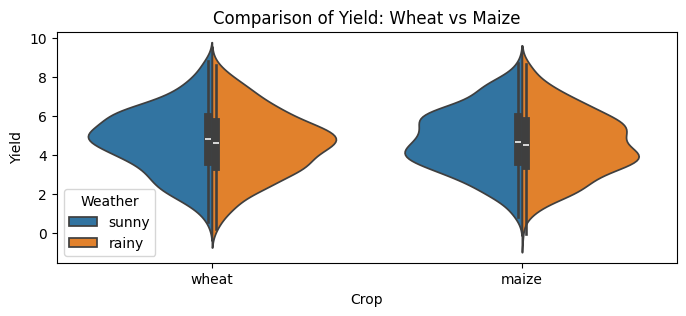

In [ ]:
df_long = crop_weather.melt(var_name='Category', value_name='Yield')
df_long[['Crop', 'Weather']] = df_long['Category'].str.split('_', expand=True)

plt.figure(figsize=(8, 3))
sns.violinplot(data=df_long, x='Crop', y='Yield', hue='Weather', split=True)

plt.title('Comparison of Yield: Wheat vs Maize')
plt.show()

### Interpretation
> How does the distribution of yield change for "Maize" vs. "Wheat" when the Weather_Condition shifts from Sunny to Rainy?

**Summary**:
There is no apparent shift in the distribution of the yields of Maize and Wheat in rainy or sunny weather conditions.

## Q4: What is the average Days_to_Harvest for each crop, and is there a correlation between growth duration and yield?

In [ ]:
# Prepare the subset
days_to_harvest = pd.concat([df.query('Crop == "Cotton"')[['Days_to_Harvest']].reset_index(drop=True),
                            df.query('Crop == "Rice"')[['Days_to_Harvest']].reset_index(drop=True),
                            df.query('Crop == "Barley"')[['Days_to_Harvest']].reset_index(drop=True),
                            df.query('Crop == "Soybean"')[['Days_to_Harvest']].reset_index(drop=True),
                            df.query('Crop == "Wheat"')[['Days_to_Harvest']].reset_index(drop=True),
                            df.query('Crop == "Maize"')[['Days_to_Harvest']].reset_index(drop=True)], axis=1)

days_to_harvest.columns = ['Cotton', 'Rice', 'Barley', 'Soybean', 'Wheat', 'Maize']

In [ ]:
# Calculate the means
for crop in pd.unique(df['Crop']):
    print(f"Mean Days_to_Harvest of {crop}:", days_to_harvest[crop].mean())

Mean Days_to_Harvest of Cotton: 104.53379956178527
Mean Days_to_Harvest of Rice: 104.50087534174301
Mean Days_to_Harvest of Barley: 104.4256462222009
Mean Days_to_Harvest of Soybean: 104.45594503122952
Mean Days_to_Harvest of Wheat: 104.51490043378351
Mean Days_to_Harvest of Maize: 104.53892725267347


In [ ]:
# Calculate the Pearson Correlation Coefficients
for crop in pd.unique(df['Crop']):
    results = df.query('Crop == @crop')[['Days_to_Harvest', 'Yield_tons_per_hectare']].reset_index(drop=True)
    correlation = results['Days_to_Harvest'].corr(results['Yield_tons_per_hectare'])
    print(f"For {crop}:", correlation)

For Cotton: 0.0014005574103619133
For Rice: -0.0029956982911345863
For Barley: -0.00040470496681060665
For Soybean: -0.005058926318216197
For Wheat: -0.0038049130418917262
For Maize: -0.004679079195342282


### Interpretation
> What is the average Days_to_Harvest for each crop, and is there a correlation between growth duration and yield?

The average days to harvest of all crops are around 104.5 days.

The pearson correlation coefficients between the growth duration and yield of all crops showed that there is no significant correlation between the two variables.

**Summary**: Mean days to harvest of all crops is 104.5 days. There is no significant correlation between the growth duration and yield of all crops.

## Q5: Is the average temperature in the "North" region significantly different from the "South" region during the growth periods recorded?

In [ ]:
# Prepare samples
north_temps = df.query('Region == "North"')[['Temperature_Celsius']].sample(n=500).reset_index(drop=True)
south_temps = df.query('Region == "South"')[['Temperature_Celsius']].sample(n=500).reset_index(drop=True)

### Check for ANOVA Assumptions

Normality of Residuals: This is formally tested using the Shapiro-Wilk test. This tests the null hypothesis that the data is normally distributed. Since our sample is large, we can use their histograms instead for visual inspection.

Homogeneity of Variance: We can formally test the homogeneity of variances using the Levene’s Test. This tests the null hypothesis that variances are homogeneous. We reject the null hypothesis if p-value < 0.05.

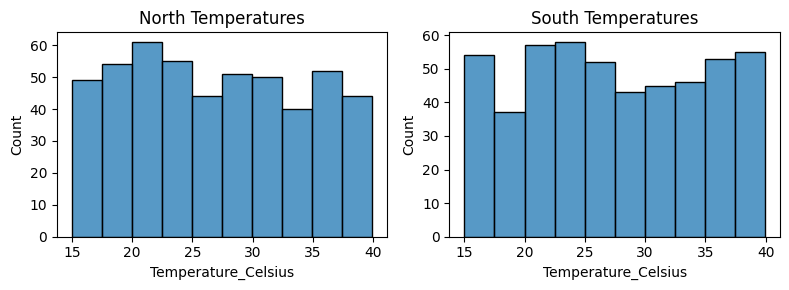

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

sns.histplot(data=north_temps, x='Temperature_Celsius', ax=axes[0])
axes[0].set_title("North Temperatures")

sns.histplot(data=south_temps, x='Temperature_Celsius', ax=axes[1])
axes[1].set_title("South Temperatures")

plt.tight_layout()
plt.show()

In [ ]:
# Levene's Test for Homogeneity of Variance
levene_stat, levene_p_value = stats.levene(north_temps, south_temps)

if levene_p_value > 0.05:
    print("The variances are equal", levene_p_value)
else:
    print("Violated! The variances are not equal", levene_p_value)

The variances are equal [0.70208683]


The normality assumption is violated. However, this passes since ANOVA is considered quite robust to moderate violations of normality. This is especially true if the sample size is large (thanks to the Central Limit Theorem) and the sample sizes are equal. Because of this, we proceed with the One-Way ANOVA.

### Hypothesis Testing using One-Way ANOVA
$H_{0}$: There is no significant difference in the average temperature between the North and South regions $(\mu_{North} = \mu_{South})$

$H_{a}$: The average temperature in the North region is significantly different from the South region $(\mu_{North} \neq \mu_{South})$

In [ ]:
f_statistic, p_value = stats.f_oneway(north_temps, south_temps)

if p_value < 0.05:
    print("There is a significant difference between the means.")
else:
    print("There is no significant difference between the means.")

There is no significant difference between the means.


### Interpretation
> Is the average temperature in the "North" region significantly different from the "South" region during the growth periods recorded?

**Summary**: The average temperature in the North region is not significantly different from the South region in the context of this dataset.

## Summary of Insights
<a id="summary"></a>

**Q1: Does applying fertilizer yield better results when combined with irrigation compared to when used alone?**
> Fertilizer is good alone. Irrigation is good alone. Fertilizer combined with Irrigation does not have special benefits.

**Q2: Is there a statistically significant difference in the mean yield between Peaty soil and Loam soil across all regions?**
> Crops planted on Peaty Soil have a higher mean yield compared to Loam Soil.

**Q3: How does the distribution of yield change for "Maize" vs. "Wheat" when the Weather_Condition shifts from Sunny to Rainy?**
> There is no apparent shift in the distribution of the yields of Maize and Wheat in rainy or sunny weather conditions.

**Q4: What is the average Days_to_Harvest for each crop, and is there a correlation between growth duration and yield?**
> Mean days to harvest of all crops is 104.5 days. There is no significant correlation between the growth duration and yield of all crops.

**Q5: Is the average temperature in the "North" region significantly different from the "South" region during the growth periods recorded?**
> The average temperature in the North region is not significantly different from the South region in the context of this dataset.

### References:
- https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield/data
- https://github.com/katiehuangx/Udacity-Data-Analyst-Nanodegree/blob/main/Project%202%20-%20TMDB%20Movie%20Analysis.ipynb